In [1]:
from feature_extractor import *
from preprocessor import *

import matplotlib.pyplot as plt
import numpy as np


In [2]:
#only for ipynb
from IPython.display import clear_output, Image, display
import PIL.Image
import io

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

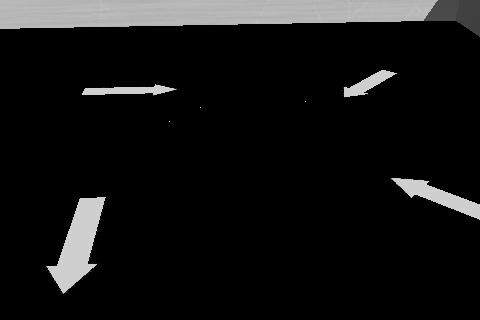

In [3]:
filename = 'samples/s8.jpg'
src = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
showarray(src)

(320, 480)


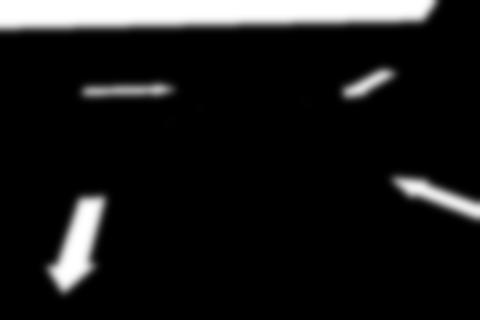

In [4]:
otsu_thresh = applyOtsu(src)
kSize = 25
src = cv2.GaussianBlur(otsu_thresh,(kSize,kSize),0)
print(src.shape)
showarray(src)

0 451 0 43


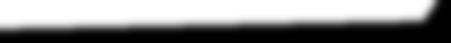

In [16]:

blobs = extract_blob(src)
largestBlob = getLblob(blobs)
testy1 = largestBlob.lowerY
testy2 = largestBlob.upperY

testx1 = largestBlob.lowerX
testx2 = largestBlob.upperX
print(testx1, testx2, testy1, testy2)
slice = make_copy(src,0, testy2, 0, testx2)
showarray(slice)

In [17]:
#TODO: Make sure to differentiate between the wall and the arrow

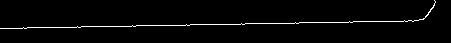

In [18]:
#TODO :add to preprocessor
cannyEdge = cv2.Canny(slice, 50, 200, None, 3)
outline = cannyEdge 
showarray(outline)

In [19]:
def drawLines(img, lines):
    src = np.copy(img)
    for i in lines:
        cv2.line(src, (i.vertex1[0],img.shape[0]-i.vertex1[1]), (i.vertex2[0],img.shape[0]-i.vertex2[1]), (0,0,0), 3, cv2.LINE_AA)
    return src

453 62 31 55
Originally has 2 lines
Line from (0,15) to (413,22) with gradenit 0.016949 , intercept 15.000000 and length 413.059318


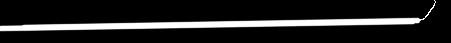

In [20]:
cdst = np.copy(outline)

error_factor = 4
image_perimeter = np.where(cdst>0)[0].shape[0]
minPoints_in_long_line = int(image_perimeter*float((8-error_factor)/29))
intersection_threshold_long = int(0.5*minPoints_in_long_line)
max_gap_lines_long = int(0.9*minPoints_in_long_line)

print(image_perimeter, minPoints_in_long_line, intersection_threshold_long, max_gap_lines_long)
stem_lines, height= openCV_houghlines(cdst, r_res=1, theta_res=np.pi/180, int_thresh=intersection_threshold_long, \
                                  l=None, minPoint_line=minPoints_in_long_line, maxLine_gap=max_gap_lines_long)

print("Originally has %i lines"%(len(stem_lines)))
#Filter most suitable lines
bestFitStem = removeDup_sortLen(stem_lines,0.1,10)[:2]
for line in bestFitStem:
    line.print_()
showarray(cdst)


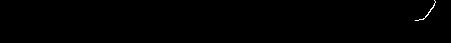

In [21]:
smImg = drawLines(outline,bestFitStem[:2])
showarray(smImg)

453 15 7 13
Originally has 1 lines
Line from (424,25) to (435,41) with gradenit 1.454545 , intercept -591.727273 and length 19.416488


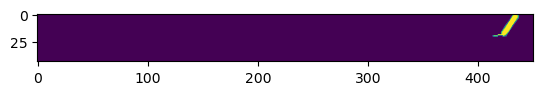

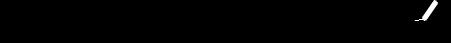

In [22]:
cdst = np.copy(smImg)

error_factor = 4
minPoints_in_line_short = int(image_perimeter*float((5-error_factor)/29))
intersection_threshold_short = int(0.5*minPoints_in_line_short)
max_gap_lines_short = int(0.9*minPoints_in_line_short)

print(image_perimeter, minPoints_in_line_short, intersection_threshold_short, max_gap_lines_short)
head_lines, height= openCV_houghlines(cdst, r_res=1, theta_res=np.pi/180, int_thresh=intersection_threshold_short, \
                                  l=None, minPoint_line=minPoints_in_line_short, maxLine_gap=max_gap_lines_short)

print("Originally has %i lines"%(len(head_lines)))
#Filter most suitable lines
bestFitHead = removeDup_sortLen(head_lines,0.1,10)

for line in bestFitHead:
    line.print_()
plt.imshow(cdst)
plt.show()
showarray(cdst)

In [23]:
ps = np.where(cdst>0)

for sLine in bestFitStem:
    vertex1_score = 0
    vertex2_score = 0
    for p_ in range(len(ps)):
        point = np.array([ps[1][p_],height-ps[0][p_]])
        vertex1_score += np.linalg.norm(sLine.vertex1-point)
        vertex2_score += np.linalg.norm(sLine.vertex2-point)
    print(vertex1_score, vertex2_score)
    if vertex1_score>vertex2_score:
        print('A',(sLine.vertex1,sLine.vertex2))
        b = bearing(sLine.vertex2[0],sLine.vertex2[1],sLine.vertex1[0],sLine.vertex1[1])
    else:
        print('B', (sLine.vertex2,sLine.vertex1))
        b = bearing(sLine.vertex1[0], sLine.vertex1[1],sLine.vertex2[0],sLine.vertex2[1])
    print(b)


868.806655220027 58.698484809834994
A (array([ 0, 15], dtype=int32), array([413,  22], dtype=int32))
180.97102193107915


In [24]:
bearing(21,47,164,211)

48.91315952498741

Long Lines Here

cdst = np.copy(outline)

lines_points , height= openCV_houghlines(cdst, r_res=1, theta_res=np.pi/180, int_thresh=60, l=None, minPoint_line=20, maxLine_gap=150)
#print(lines_points)
lines_Eqns = get_lines(lines_points)
print("lines detected: ", len(lines_points))
showarray(cdst)

Debug the short line distances here

In [25]:

for i in range(len(bestFitHead)):
    for j in range(i+1, len(bestFitHead)):
        x = intersects(cdst.shape, bestFitHead[i], bestFitHead[j])
        if x[0]==True:
            bestFitHead[i].print_()            
            bestFitHead[j].print_()
            vertex = x[1]

In [26]:
midpoint = (bestFitStem[0].get_midpoint()+bestFitStem[1].get_midpoint())/2
print(midpoint)
print(bearing(midpoint[0],midpoint[1],vertex[0],vertex[1]))

IndexError: list index out of range

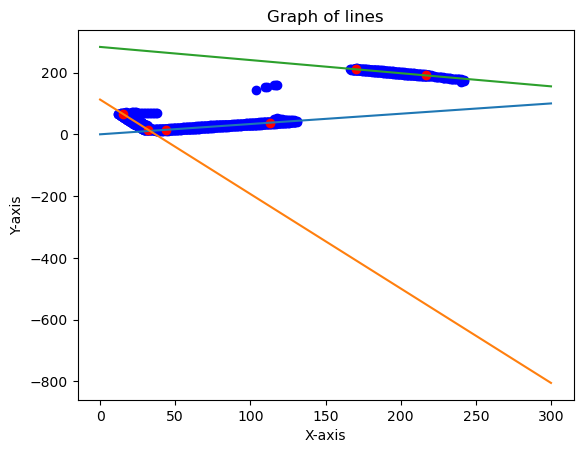

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



x_points=  list(ps[1])
y_points = list(height-ps[0])

plt.scatter(x_points, y_points, color='blue')

x_points = []
y_points = []

for l in bestFitHead:
    x_points.append(l.vertex1[0])
    x_points.append(l.vertex2[0])
    y_points.append(l.vertex1[1])
    y_points.append(l.vertex2[1])

plt.scatter(x_points, y_points, color='red')

x = np.linspace(0, 300, 100)

for l in bestFitHead:
    y = l.get_gradient() * x + l.get_intercept()
    plt.plot(x,y)


# plt.ylim(-30,height)
# plt.xlim(0,400)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Graph of lines')
plt.show()
